``` python
# if you running at azure nootbook to prepare env
#!pip install lxml --ignore-installed lxml
#!pip install tushare==1.2.54 
```

In [42]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
from logging.config import fileConfig

from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline

from greenseer.configuration import do_global_configuration
from greenseer.dataset.china_dataset import TRAIN_SET_ALL, fetch_train_set
from greenseer.preprocessing.clean_data import remove_inf_and_na, RemoveAbnormalFilter
from greenseer.preprocessing.transformers import regular_expression_column_filter, \
    pick_annual_report_china, append_industry_transform, re_percent_column_transform
from greenseer.utils.tools import save_fig, save_csv
%matplotlib inline

do_global_configuration("config.properties")
fileConfig('logging_config.ini')



In [44]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as mfm
from pylab import mpl
font_path = 'SourceHanSerifSC-ExtraLight.otf'
prop = mfm.FontProperties(fname=font_path)
mpl.rcParams['axes.unicode_minus'] = False
mpl.rcParams['font.sans-serif'] = ['Source Han Serif SC'] # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
mfm._rebuild()
plt.rcParams['font.family'] = 'Source Han Serif SC'
mpl.rcParams['font.sans-serif'] = ['Source Han Serif SC'] # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题

- 600519：茅台

In [45]:
# reports = fetch_multi_report(stock_ids=np.array(["600519","600520"]))
reports = fetch_train_set(TRAIN_SET_ALL)

In [46]:
subjects = [r'\w*应付\w*|\w*应收\w*|存货|货币资金|\w*生物\w*|\w*资产总计\w*']
final_subjects = [r'industry|payable|receivable|base']
payable_subject = 'payable'
receivable_subject = 'receivable'

prepare_pipeline = Pipeline([
        ('pick_annual_report', pick_annual_report_china()),
        ('pick_subject', regular_expression_column_filter(patterns=subjects,rename={"资产总计(万元)":"base"})),
        ('percent payable', re_percent_column_transform(numerator=[r'\w*应付\w*'], denominator=[r'base'],new_name=payable_subject)),
        ('percent receivable', re_percent_column_transform(numerator=[r'\w*应收\w*'], denominator=[r'base'],new_name=receivable_subject)),
        ('append industry',append_industry_transform()),
        ('clean data',remove_inf_and_na()),
        ('pick_final_subject', regular_expression_column_filter(patterns=final_subjects)),
        ('remove abnormal',RemoveAbnormalFilter([payable_subject, receivable_subject]))

])

data = prepare_pipeline.fit_transform(reports)

In [47]:
summary_by_category = data.groupby("industry")
mean= summary_by_category.mean()

Saving figure attribute_histogram_plots
Saving scv: ./csv/test.csv
Saving scv: ./csv/all.csv


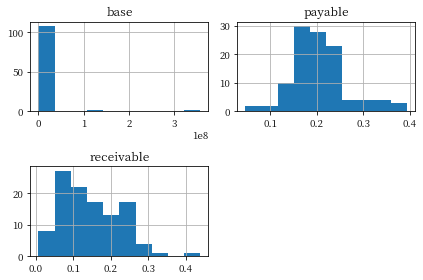

In [48]:
mean.hist()
save_fig("attribute_histogram_plots")
save_csv(data=mean,name="test")
save_csv(data=data,name="all")

Saving scv: ./csv/industry_group.csv
Saving figure industry_group


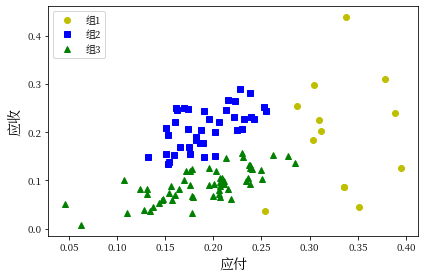

In [49]:
X = mean[[payable_subject,receivable_subject]].values

y_pred = GaussianMixture(n_components=3, random_state=42).fit(X).predict(X)
mean["group"] = y_pred
save_csv(data=mean,name="industry_group")

plt.plot(X[y_pred==0, 0], X[y_pred==0, 1], "yo", label="组1")
plt.plot(X[y_pred==1, 0], X[y_pred==1, 1], "bs", label="组2")
plt.plot(X[y_pred==2, 0], X[y_pred==2, 1], "g^", label="组3")
plt.xlabel("应付", fontsize=14)
plt.ylabel("应收", fontsize=14)
plt.legend(loc="upper left")
save_fig("industry_group")
plt.show()